In [16]:
import zipfile
import os

# 压缩包文件名（放在当前 notebook 所在目录）
zip_path = 'C:/Users/86173/Desktop/archive.zip'

# 解压目标文件夹
extract_to = 'archive_extracted'
os.makedirs(extract_to, exist_ok=True)

# 解压压缩包
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ 解压完成！文件已保存至：", extract_to)


✅ 解压完成！文件已保存至： archive_extracted


In [17]:
# 查看解压后的所有文件
import os

for root, dirs, files in os.walk(extract_to):
    for file in files:
        print(file)



Google-Playstore.csv


In [19]:
import pandas as pd

csv_path = os.path.join(extract_to, 'Google-Playstore.csv')  
df = pd.read_csv(csv_path)

# 显示前几行
df.head()


,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [20]:
# 查看数据基本信息
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
count,2312939,2312944,2312944,2.290061e+06,2.290061e+06,2312837,2.312837e+06,2.312944e+06,2312944,2.312944e+06,...,1552109,2312913,2241891,2312944,2312944,1891991,2312944,2312944,2312944,2312944
unique,2177943,2312944,48,NaN,NaN,22,NaN,NaN,2,NaN,...,810440,950456,4158,3918,6,977743,2,2,2,67374
top,Tic Tac Toe,com.ishakwe.gakondo,Education,NaN,NaN,100+,NaN,NaN,True,NaN,...,http://www.subsplash.com/,support@classplus.co,"Jun 16, 2020","Jun 10, 2021",Everyone,http://www.subsplash.com/legal/privacy,False,False,False,2021-06-16 07:35:57
freq,382,1,241090,NaN,NaN,443368,NaN,NaN,2267876,NaN,...,7519,10345,2051,11186,2022089,7481,1162170,2117635,2312091,56
mean,NaN,NaN,NaN,2.203152e+00,2.864839e+03,NaN,1.834452e+05,3.202017e+05,NaN,1.034992e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,2.106223e+00,2.121626e+05,NaN,1.513144e+07,2.355495e+07,NaN,2.633127e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,5.000000e+01,8.400000e+01,NaN,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2.900000e+00,6.000000e+00,NaN,5.000000e+02,6.950000e+02,NaN,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,4.300000e+00,4.200000e+01,NaN,5.000000e+03,7.354000e+03,NaN,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# 1. 删除重复值
df.drop_duplicates(inplace=True)

# 2. 删除空 App 名称或类别的行
df.dropna(subset=['App Name', 'Category'], inplace=True)

# 3. Installs 字段清理：去掉 "+" 和 "," 并转为整数
df['Installs'] = df['Installs'].str.replace(r'[+,]', '', regex=True).astype('float')

# 4. 转换日期字段
df['Released'] = pd.to_datetime(df['Released'], errors='coerce')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')


<Axes: title={'center': 'Top 10 App Categories'}, xlabel='Category'>

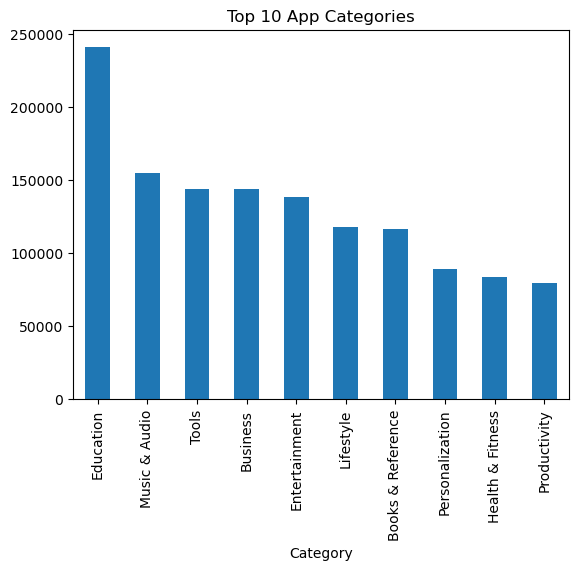

In [22]:
df['Category'].value_counts().head(10).plot(kind='bar', title='Top 10 App Categories')

<Axes: title={'center': 'Free vs Paid Apps'}, ylabel='count'>

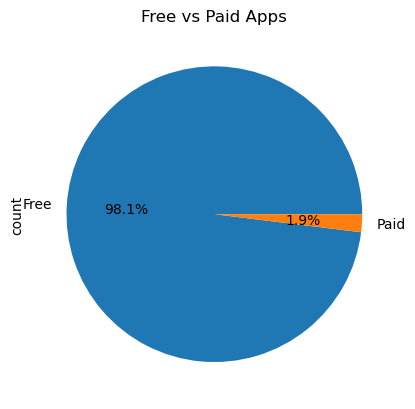

In [23]:
df['Free'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Free', 'Paid'], title='Free vs Paid Apps')


<Axes: >

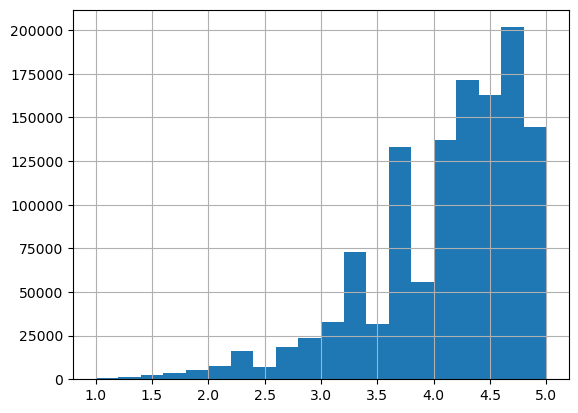

In [24]:
df[df['Rating'] > 0]['Rating'].hist(bins=20)


In [25]:
df[['App Name', 'Installs']].sort_values('Installs', ascending=False).head(10)


,App Name,Installs
2155096,Google Play services,1.000000e+10
2099458,Gmail,5.000000e+09
944254,Google Chrome: Fast & Secure,5.000000e+09
2222701,Facebook,5.000000e+09
881403,YouTube,5.000000e+09
2095852,Messenger – Text and Video Chat for Free,5.000000e+09
2011395,Android Accessibility Suite,5.000000e+09
1733042,Google Maps - Navigate & Explore,5.000000e+09
1060335,Google Text-to-Speech,5.000000e+09
167781,Google TV (previously Play Movies & TV),5.000000e+09


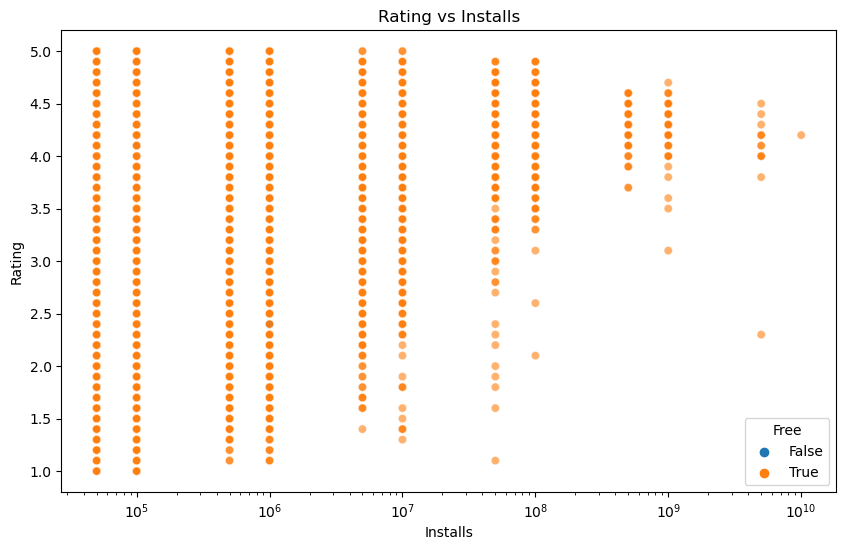

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 安装量与评分的关系（仅保留评分非空、安装量较大的记录）
df_filtered = df[(df['Rating'] > 0) & (df['Installs'] > 10000)]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_filtered, x='Installs', y='Rating', hue='Free', alpha=0.6)
plt.title('Rating vs Installs')
plt.xscale('log')  # 安装量范围大，使用对数轴
plt.show()


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')



In [29]:
print("=== 数据基本信息 ===")
print(f"数据集形状: {df.shape}")
print(f"列名: {list(df.columns)}")
print("\n数据前5行:")
print(df.head())

=== 数据基本信息 ===
数据集形状: (2312939, 24)
列名: ['App Name', 'App Id', 'Category', 'Rating', 'Rating Count', 'Installs', 'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Currency', 'Size', 'Minimum Android', 'Developer Id', 'Developer Website', 'Developer Email', 'Released', 'Last Updated', 'Content Rating', 'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice', 'Scraped Time']

数据前5行:
                                            App Name  \
0                                            Gakondo   
1                                Ampere Battery Info   
2                                             Vibook   
3  Smart City Trichy Public Service Vehicles 17UC...   
4                                            GROW.me   

                       App Id       Category  Rating  Rating Count  Installs  \
0         com.ishakwe.gakondo      Adventure     0.0           0.0      10.0   
1  com.webserveis.batteryinfo          Tools     4.4          64.0    5000.0   
2        com.doa

In [30]:
# ===============================
# 1. 数据预处理和清洗
# ===============================

def clean_installs(installs_str):
    """清洗安装数量数据"""
    if pd.isna(installs_str):
        return np.nan
    # 移除逗号和加号
    clean_str = str(installs_str).replace(',', '').replace('+', '')
    try:
        return float(clean_str)
    except:
        return np.nan

def clean_price(price):
    """清洗价格数据"""
    if pd.isna(price):
        return 0.0
    if isinstance(price, str):
        # 移除货币符号
        price = price.replace('$', '').replace('€', '').replace('£', '')
        try:
            return float(price)
        except:
            return 0.0
    return float(price)

# 数据清洗
print("\n=== 数据清洗 ===")
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Rating_Count'] = pd.to_numeric(df['Rating Count'], errors='coerce')
df['Price_Clean'] = df['Price'].apply(clean_price)
df['Installs_Clean'] = df['Minimum Installs'].apply(clean_installs)

# 创建受欢迎程度排名（基于安装数量的倒序排名）
df['Popularity_Rank'] = df['Installs_Clean'].rank(method='dense', ascending=False)

# 移除缺失值和异常值
df_clean = df.dropna(subset=['Rating', 'Price_Clean', 'Installs_Clean'])
# 移除评分为0的应用（通常表示没有评分）
df_clean = df_clean[df_clean['Rating'] > 0]
# 移除安装量为0的应用
df_clean = df_clean[df_clean['Installs_Clean'] > 0]

print(f"清洗后数据集形状: {df_clean.shape}")

# 对于大数据集，我们可以进行采样以提高分析效率
if len(df_clean) > 100000:
    print("数据集较大，进行分层采样...")
    # 按类别进行分层采样
    sample_size = min(50000, len(df_clean))
    df_sample = df_clean.groupby('Category', group_keys=False).apply(
        lambda x: x.sample(min(len(x), max(1, int(sample_size * len(x) / len(df_clean)))), 
                          random_state=42)
    ).reset_index(drop=True)
    print(f"采样后数据集形状: {df_sample.shape}")
    # 使用采样数据进行后续分析
    df_analysis = df_sample.copy()
else:
    df_analysis = df_clean.copy()


=== 数据清洗 ===
清洗后数据集形状: (1230151, 28)
数据集较大，进行分层采样...
采样后数据集形状: (49976, 28)


In [31]:
# ===============================
# 2. 描述性统计分析
# ===============================

print("\n=== 描述性统计分析 ===")
stats_summary = df_analysis[['Rating', 'Price_Clean', 'Installs_Clean', 'Popularity_Rank']].describe()
print(stats_summary)

# 添加一些额外的统计信息
print(f"\n额外统计信息:")
print(f"免费应用占比: {(df_analysis['Price_Clean'] == 0).mean():.1%}")
print(f"付费应用占比: {(df_analysis['Price_Clean'] > 0).mean():.1%}")
print(f"平均评分: {df_analysis['Rating'].mean():.2f}")
print(f"评分中位数: {df_analysis['Rating'].median():.2f}")
print(f"高评分应用(≥4.0)占比: {(df_analysis['Rating'] >= 4.0).mean():.1%}")
print(f"总类别数: {df_analysis['Category'].nunique()}")
print(f"最受欢迎的类别: {df_analysis['Category'].value_counts().head(1).index[0]}")


=== 描述性统计分析 ===
             Rating   Price_Clean  Installs_Clean  Popularity_Rank
count  49976.000000  49976.000000    4.997600e+04     49976.000000
mean       4.098295      0.095731    2.610061e+05        13.982772
std        0.690297      2.255652    7.522591e+06         2.223492
min        1.000000      0.000000    1.000000e+00         3.000000
25%        3.800000      0.000000    1.000000e+03        13.000000
50%        4.200000      0.000000    5.000000e+03        14.000000
75%        4.600000      0.000000    1.000000e+04        15.000000
max        5.000000    399.990000    1.000000e+09        21.000000

额外统计信息:
免费应用占比: 97.9%
付费应用占比: 2.1%
平均评分: 4.10
评分中位数: 4.20
高评分应用(≥4.0)占比: 66.2%
总类别数: 48
最受欢迎的类别: Education


In [32]:
# ===============================
# 3. 相关性分析 (Pearson 和 Spearman)
# ===============================

print("\n=== 相关性分析 ===")

# 选择分析变量
analysis_vars = ['Rating', 'Price_Clean', 'Installs_Clean', 'Popularity_Rank']
correlation_data = df_analysis[analysis_vars]

# Pearson相关系数
pearson_corr = correlation_data.corr(method='pearson')
print("Pearson 相关系数矩阵:")
print(pearson_corr)

# Spearman相关系数
spearman_corr = correlation_data.corr(method='spearman')
print("\nSpearman 相关系数矩阵:")
print(spearman_corr)

# 显著性检验
def correlation_significance_test(data, method='pearson'):
    """计算相关系数的显著性"""
    variables = data.columns
    n = len(variables)
    p_values = np.zeros((n, n))
    
    for i, var1 in enumerate(variables):
        for j, var2 in enumerate(variables):
            if i != j:
                if method == 'pearson':
                    corr, p_val = stats.pearsonr(data[var1], data[var2])
                else:  # spearman
                    corr, p_val = stats.spearmanr(data[var1], data[var2])
                p_values[i, j] = p_val
            else:
                p_values[i, j] = 0
    
    return pd.DataFrame(p_values, index=variables, columns=variables)

pearson_p_values = correlation_significance_test(correlation_data, 'pearson')
spearman_p_values = correlation_significance_test(correlation_data, 'spearman')

print("\nPearson 相关系数 p值:")
print(pearson_p_values)
print("\nSpearman 相关系数 p值:")
print(spearman_p_values)


=== 相关性分析 ===
Pearson 相关系数矩阵:
                   Rating  Price_Clean  Installs_Clean  Popularity_Rank
Rating           1.000000     0.002953        0.003810         0.228478
Price_Clean      0.002953     1.000000       -0.001409         0.025568
Installs_Clean   0.003810    -0.001409        1.000000        -0.118388
Popularity_Rank  0.228478     0.025568       -0.118388         1.000000

Spearman 相关系数矩阵:
                   Rating  Price_Clean  Installs_Clean  Popularity_Rank
Rating           1.000000     0.007543       -0.320503         0.320503
Price_Clean      0.007543     1.000000       -0.081250         0.081250
Installs_Clean  -0.320503    -0.081250        1.000000        -1.000000
Popularity_Rank  0.320503     0.081250       -1.000000         1.000000

Pearson 相关系数 p值:
                   Rating   Price_Clean  Installs_Clean  Popularity_Rank
Rating           0.000000  5.091996e-01    3.943606e-01     0.000000e+00
Price_Clean      0.509200  0.000000e+00    7.528090e-01     1.08702

Starting advanced correlation analysis...
=== 1. Scatter Plot Analysis: Visualizing Non-linear Relationships ===


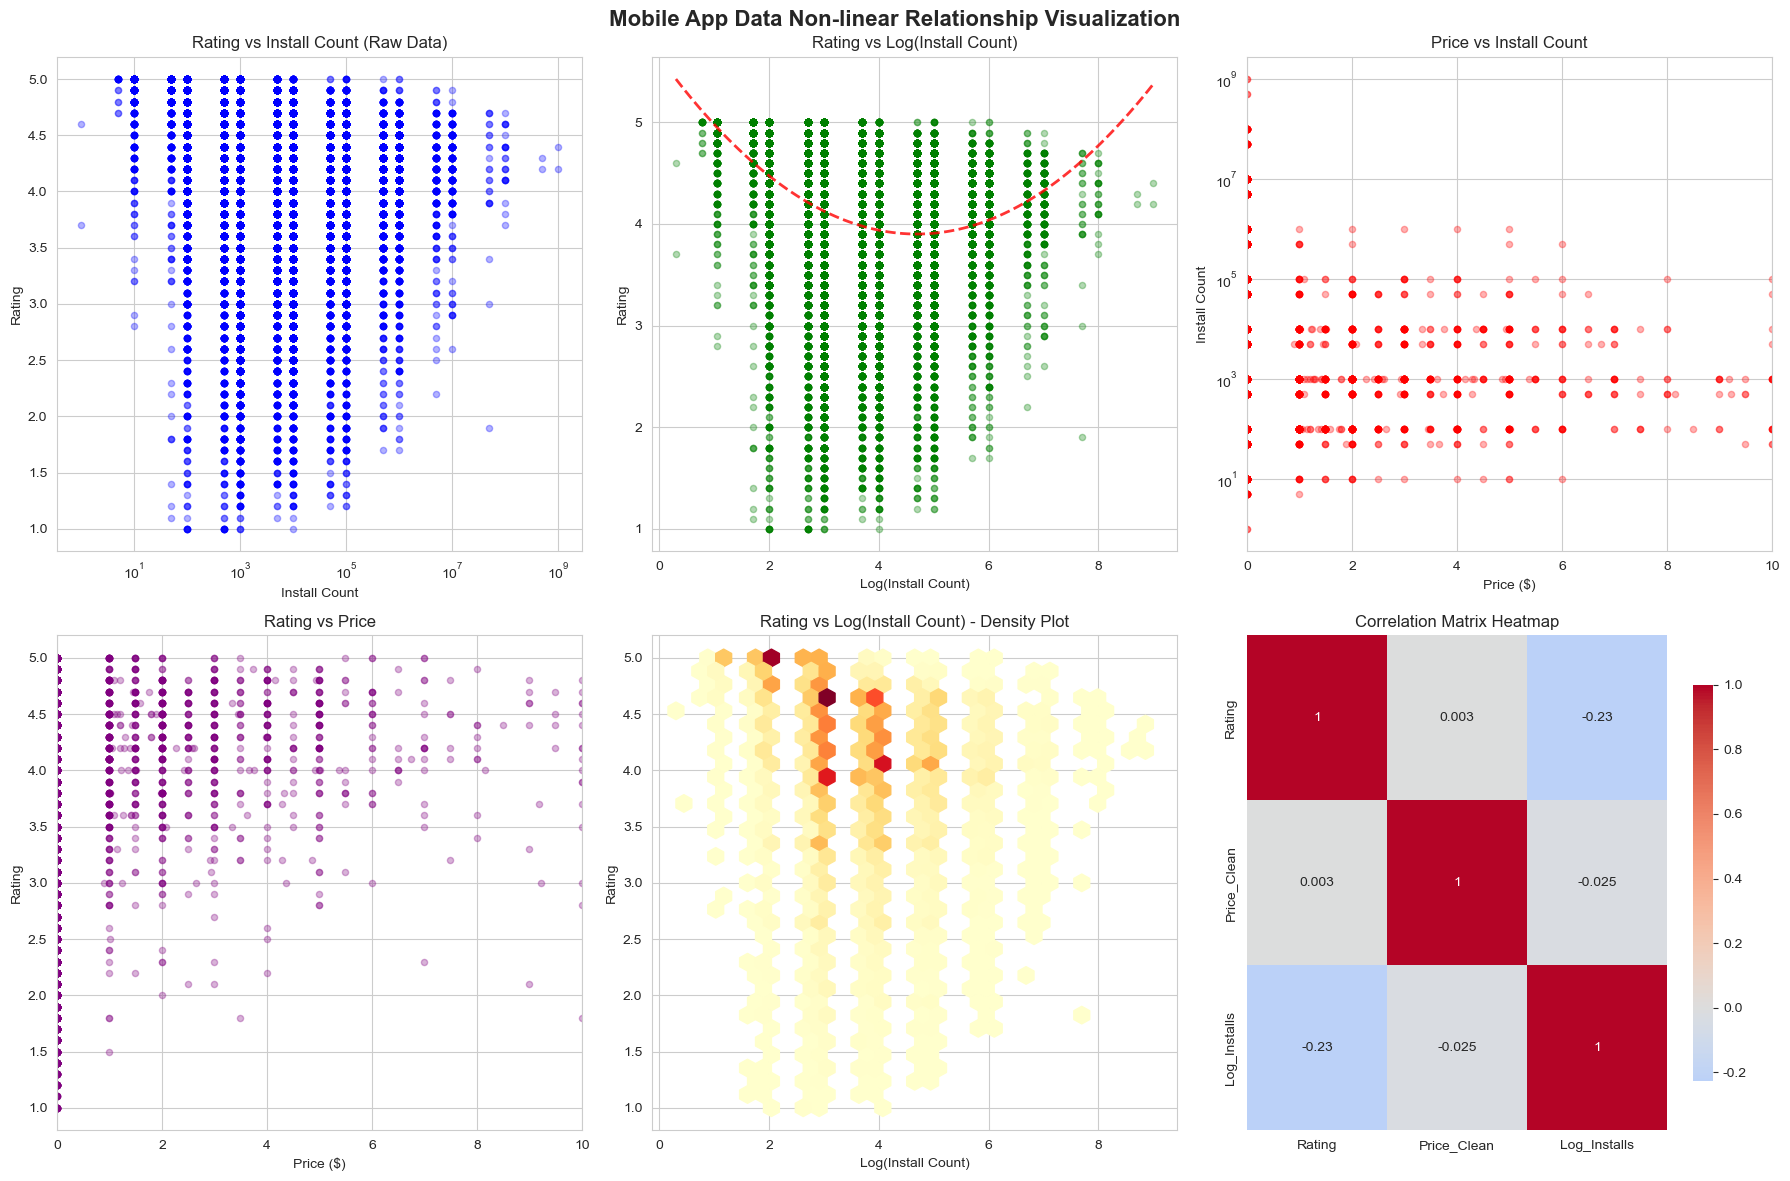

Log(Install Count) vs Rating:
  Pearson correlation: r=-0.2268, p=0.0000
  Spearman correlation: r=-0.3205, p=0.0000

=== 2. Category-wise Correlation Analysis ===

Category-wise correlation analysis results:
            Category  Sample_Size  Rating_Mean  Rating_Installs_Spearman  \
7           Business         2052       4.0456                   -0.4732   
0          Education         5212       4.1948                   -0.3370   
6          Lifestyle         2244       4.1093                   -0.2969   
2      Entertainment         3396       3.9975                   -0.2785   
3      Music & Audio         3258       4.2890                   -0.2480   
1              Tools         3456       3.9286                   -0.2334   
5    Personalization         2349       4.2478                   -0.1380   
4  Books & Reference         2724       4.2909                   -0.1210   

   Rating_Price_Pearson  
7                0.0199  
0                0.0038  
6                0.0066  
2 

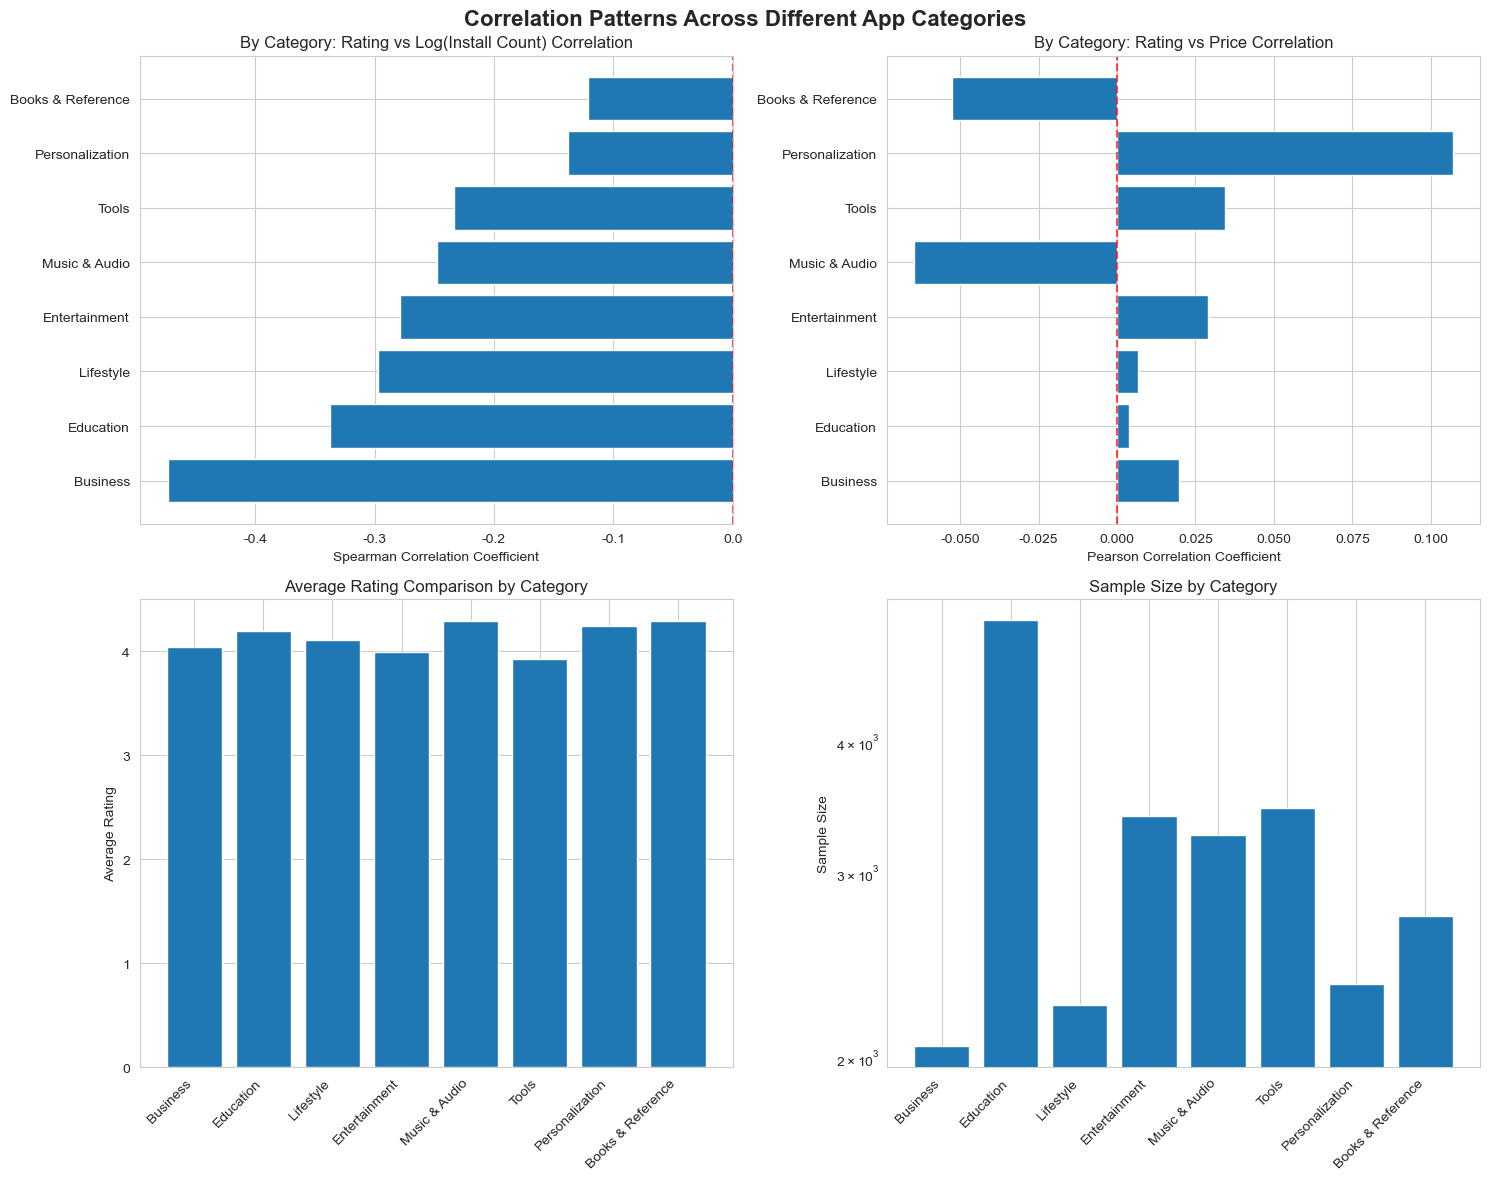


=== 3. Outlier Analysis: Identifying Phenomenal Apps ===
Install count outliers: 3789
Rating outliers: 1805
Price outliers: 1068

Phenomenal app statistics:

Blockbuster High Quality (600 apps):
  Average rating: 4.601
  Average installs: 3,654,167
  Average price: $0.02

Blockbuster Low Quality (421 apps):
  Average rating: 3.115
  Average installs: 1,684,086
  Average price: $0.00

Niche Premium (11432 apps):
  Average rating: 4.809
  Average installs: 525
  Average price: $0.12

High Price Apps (49976 apps):
  Average rating: 4.098
  Average installs: 261,006
  Average price: $0.10

DBSCAN clustering results:
Found 7 clusters
Outliers (noise points): 532


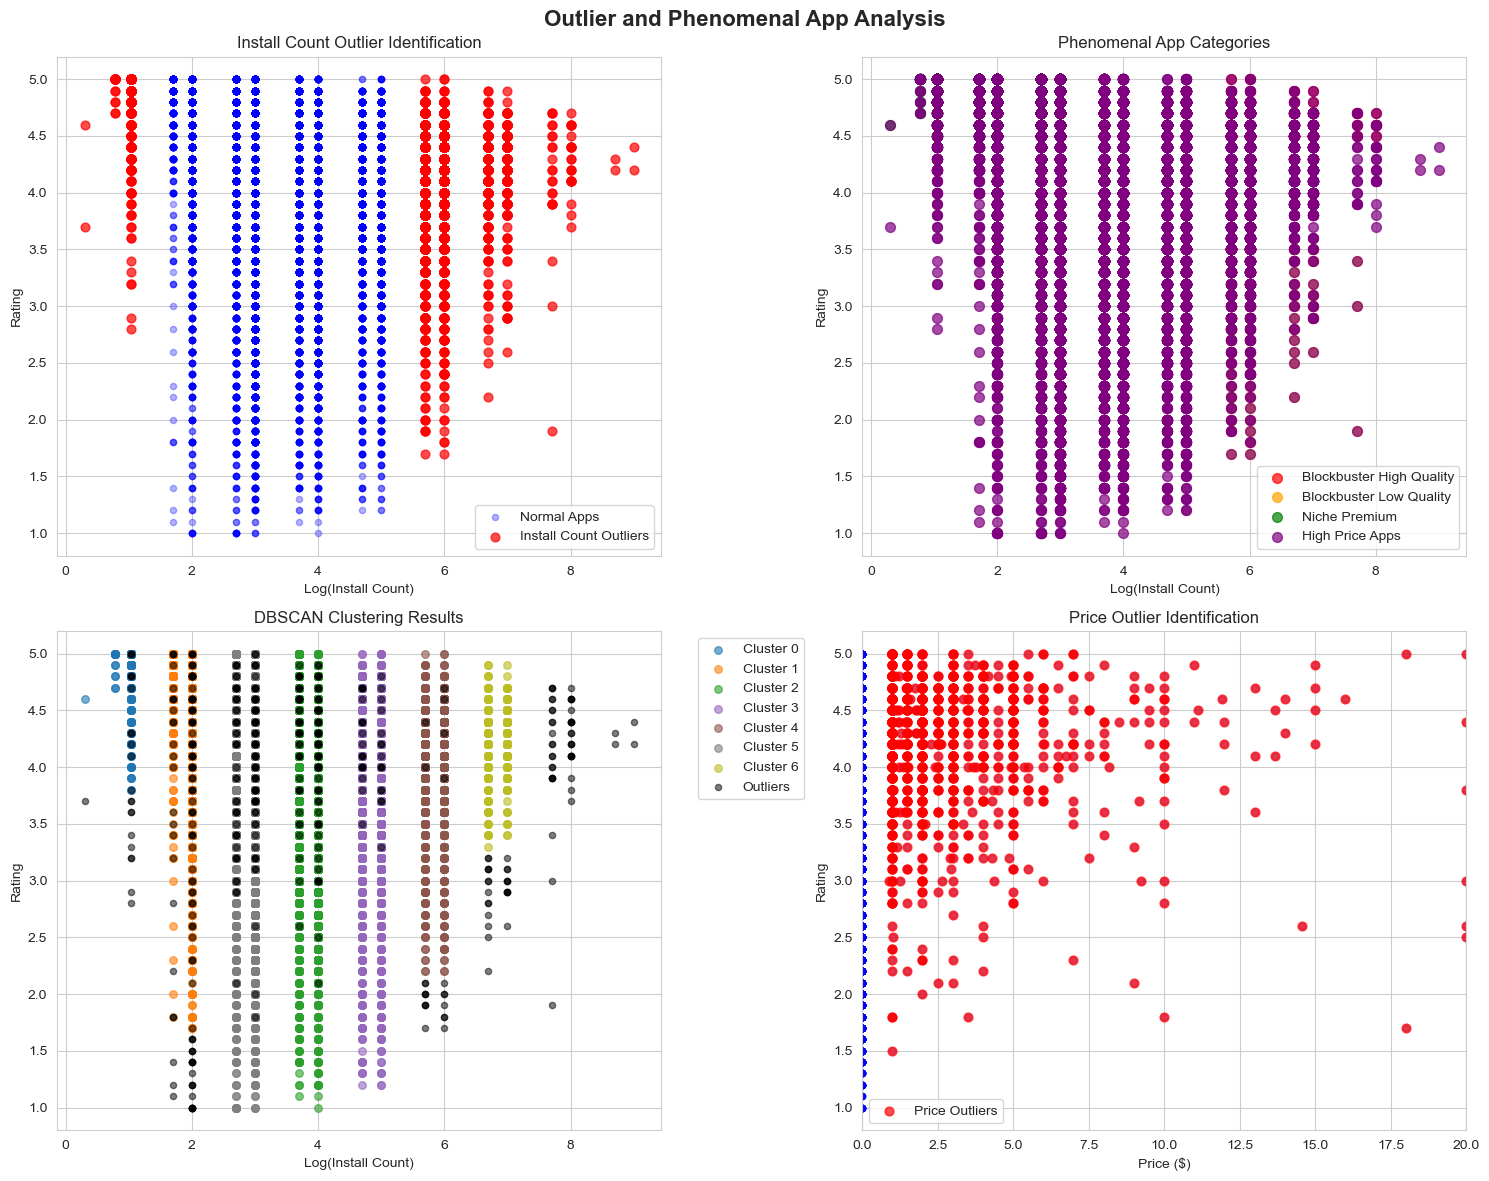


=== 4. Non-linear Modeling Analysis ===
Modeling data size: 48823
Polynomial regression (degree 1): R² = 0.0719
Polynomial regression (degree 2): R² = 0.1151
Polynomial regression (degree 3): R² = 0.1160
Polynomial regression (degree 4): R² = 0.1185
Piecewise linear regression: R² = 0.0989
  Breakpoint location: Log(Install Count) = 3.00
  Left segment slope: -0.0468, Right segment slope: 0.0019


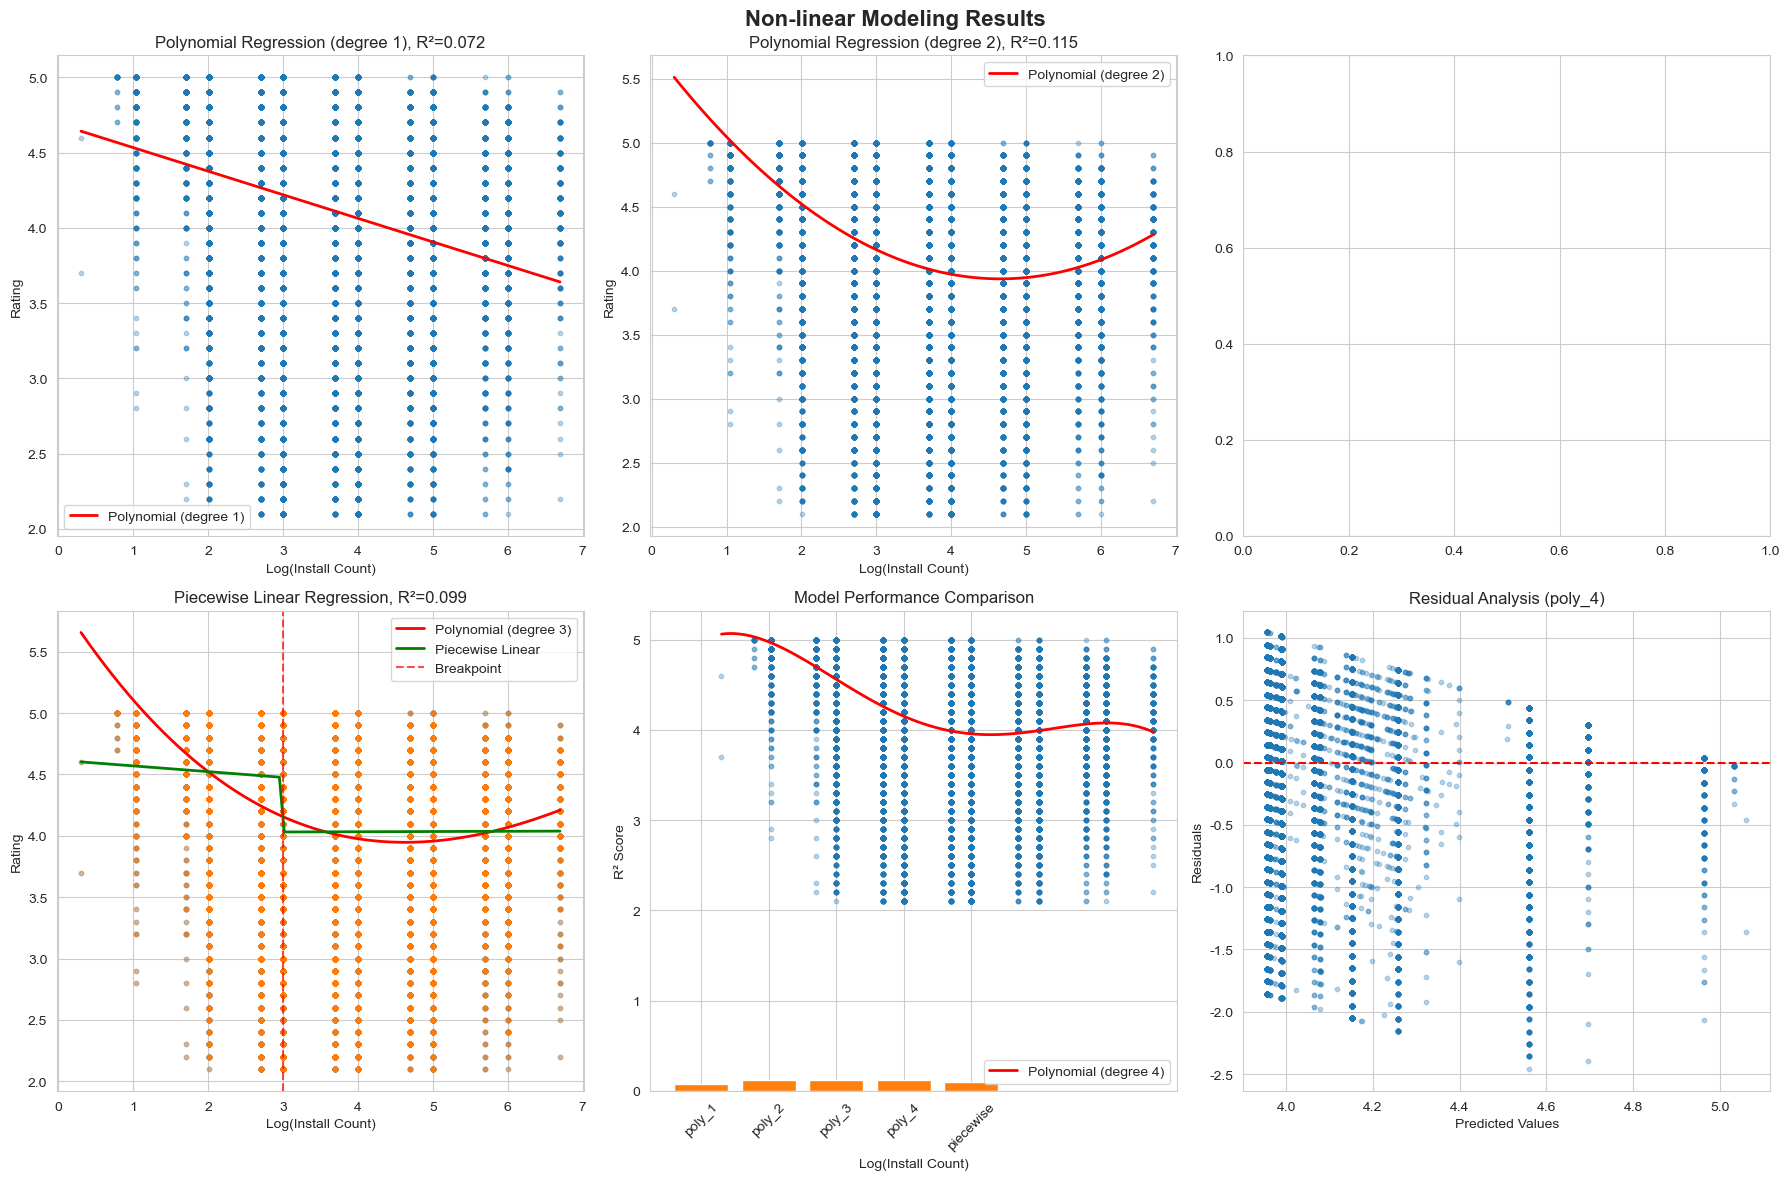


Modeling results summary:
Best model: poly_4 (R² = 0.1185)
Piecewise regression R² = 0.0989

Feature importance (based on poly_4):
  Log_Installs: 0.3943
  Price_Clean: -0.3805
  Log_Installs^2: -3.9878
  Log_Installs Price_Clean: 0.4711
  Price_Clean^2: 0.4097
  Log_Installs^3: 5.9114
  Log_Installs^2 Price_Clean: -0.1855
  Log_Installs Price_Clean^2: -0.2251
  Price_Clean^3: -0.3128
  Log_Installs^4: -2.4888
  Log_Installs^3 Price_Clean: 0.0062
  Log_Installs^2 Price_Clean^2: 0.0717
  Log_Installs Price_Clean^3: 0.0058
  Price_Clean^4: 0.1297

Advanced correlation analysis completed!
Category analysis results:
            Category  Sample_Size  Rating_Mean  Rating_Installs_Pearson  \
7           Business         2052     4.045565                -0.370060   
0          Education         5212     4.194839                -0.239766   
6          Lifestyle         2244     4.109314                -0.213752   
2      Entertainment         3396     3.997527                -0.213150   
3   

In [48]:
#相关性分析之后进一步制作散点图、分类别分析、异常值分析、非线性建模
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def create_scatter_plots(df):
    """
    1. Create scatter plots: Visualize non-linear relationships
    """
    print("=== 1. Scatter Plot Analysis: Visualizing Non-linear Relationships ===")
    
    # Data preprocessing: Handle extreme values and zeros
    df_viz = df.copy()
    df_viz['Log_Installs'] = np.log10(df_viz['Installs_Clean'] + 1)
    df_viz['Log_Price'] = np.log10(df_viz['Price_Clean'] + 0.01)  # Avoid log(0)
    
    # Create comprehensive scatter plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Mobile App Data Non-linear Relationship Visualization', fontsize=16, fontweight='bold')
    
    # 1.1 Rating vs Install Count (Raw data)
    axes[0,0].scatter(df_viz['Installs_Clean'], df_viz['Rating'], 
                     alpha=0.3, s=20, c='blue')
    axes[0,0].set_xlabel('Install Count')
    axes[0,0].set_ylabel('Rating')
    axes[0,0].set_title('Rating vs Install Count (Raw Data)')
    axes[0,0].set_xscale('log')
    
    # 1.2 Rating vs Log Install Count
    axes[0,1].scatter(df_viz['Log_Installs'], df_viz['Rating'], 
                     alpha=0.3, s=20, c='green')
    axes[0,1].set_xlabel('Log(Install Count)')
    axes[0,1].set_ylabel('Rating')
    axes[0,1].set_title('Rating vs Log(Install Count)')
    
    # Add trend line
    z = np.polyfit(df_viz['Log_Installs'], df_viz['Rating'], 2)
    p = np.poly1d(z)
    x_trend = np.linspace(df_viz['Log_Installs'].min(), df_viz['Log_Installs'].max(), 100)
    axes[0,1].plot(x_trend, p(x_trend), 'r--', alpha=0.8, linewidth=2)
    
    # 1.3 Price vs Install Count
    axes[0,2].scatter(df_viz['Price_Clean'], df_viz['Installs_Clean'], 
                     alpha=0.3, s=20, c='red')
    axes[0,2].set_xlabel('Price ($)')
    axes[0,2].set_ylabel('Install Count')
    axes[0,2].set_title('Price vs Install Count')
    axes[0,2].set_yscale('log')
    axes[0,2].set_xlim(0, 10)  # Limit price range for better observation
    
    # 1.4 Rating vs Price
    axes[1,0].scatter(df_viz['Price_Clean'], df_viz['Rating'], 
                     alpha=0.3, s=20, c='purple')
    axes[1,0].set_xlabel('Price ($)')
    axes[1,0].set_ylabel('Rating')
    axes[1,0].set_title('Rating vs Price')
    axes[1,0].set_xlim(0, 10)
    
    # 1.5 Density scatter plot: Rating vs Install Count
    axes[1,1].hexbin(df_viz['Log_Installs'], df_viz['Rating'], 
                    gridsize=30, cmap='YlOrRd', mincnt=1)
    axes[1,1].set_xlabel('Log(Install Count)')
    axes[1,1].set_ylabel('Rating')
    axes[1,1].set_title('Rating vs Log(Install Count) - Density Plot')
    
    # 1.6 Correlation heatmap
    corr_data = df_viz[['Rating', 'Price_Clean', 'Log_Installs']].corr()
    sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
                ax=axes[1,2], cbar_kws={'shrink': 0.8})
    axes[1,2].set_title('Correlation Matrix Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlations
    pearson_corr = stats.pearsonr(df_viz['Log_Installs'], df_viz['Rating'])
    spearman_corr = stats.spearmanr(df_viz['Log_Installs'], df_viz['Rating'])
    
    print(f"Log(Install Count) vs Rating:")
    print(f"  Pearson correlation: r={pearson_corr[0]:.4f}, p={pearson_corr[1]:.4f}")
    print(f"  Spearman correlation: r={spearman_corr[0]:.4f}, p={spearman_corr[1]:.4f}")

def category_analysis(df):
    """
    2. Category-wise analysis: Different app categories may have different patterns
    """
    print("\n=== 2. Category-wise Correlation Analysis ===")
    
    # Select major categories (categories with >1000 samples)
    category_counts = df['Category'].value_counts()
    major_categories = category_counts[category_counts > 1000].index[:8]
    
    # Calculate correlations for each category
    category_corr_results = []
    
    for category in major_categories:
        cat_data = df[df['Category'] == category].copy()
        cat_data['Log_Installs'] = np.log10(cat_data['Installs_Clean'] + 1)
        
        if len(cat_data) > 50:  # Ensure sufficient sample size
            # Calculate correlations
            rating_installs_pearson = stats.pearsonr(cat_data['Log_Installs'], cat_data['Rating'])
            rating_installs_spearman = stats.spearmanr(cat_data['Log_Installs'], cat_data['Rating'])
            rating_price_pearson = stats.pearsonr(cat_data['Price_Clean'], cat_data['Rating'])
            
            category_corr_results.append({
                'Category': category,
                'Sample_Size': len(cat_data),
                'Rating_Mean': cat_data['Rating'].mean(),
                'Rating_Installs_Pearson': rating_installs_pearson[0],
                'Rating_Installs_Pearson_p': rating_installs_pearson[1],
                'Rating_Installs_Spearman': rating_installs_spearman[0],
                'Rating_Installs_Spearman_p': rating_installs_spearman[1],
                'Rating_Price_Pearson': rating_price_pearson[0],
                'Rating_Price_Pearson_p': rating_price_pearson[1]
            })
    
    # Convert to DataFrame
    corr_df = pd.DataFrame(category_corr_results)
    corr_df = corr_df.sort_values('Rating_Installs_Spearman', key=abs, ascending=False)
    
    print("\nCategory-wise correlation analysis results:")
    print(corr_df[['Category', 'Sample_Size', 'Rating_Mean', 
                   'Rating_Installs_Spearman', 'Rating_Price_Pearson']].round(4))
    
    # Visualize category differences
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Correlation Patterns Across Different App Categories', fontsize=16, fontweight='bold')
    
    # 2.1 Rating-Install correlation by category
    axes[0,0].barh(range(len(corr_df)), corr_df['Rating_Installs_Spearman'])
    axes[0,0].set_yticks(range(len(corr_df)))
    axes[0,0].set_yticklabels(corr_df['Category'], fontsize=10)
    axes[0,0].set_xlabel('Spearman Correlation Coefficient')
    axes[0,0].set_title('By Category: Rating vs Log(Install Count) Correlation')
    axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    # 2.2 Rating-Price correlation by category
    axes[0,1].barh(range(len(corr_df)), corr_df['Rating_Price_Pearson'])
    axes[0,1].set_yticks(range(len(corr_df)))
    axes[0,1].set_yticklabels(corr_df['Category'], fontsize=10)
    axes[0,1].set_xlabel('Pearson Correlation Coefficient')
    axes[0,1].set_title('By Category: Rating vs Price Correlation')
    axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    
    # 2.3 Average rating by category
    axes[1,0].bar(range(len(corr_df)), corr_df['Rating_Mean'])
    axes[1,0].set_xticks(range(len(corr_df)))
    axes[1,0].set_xticklabels(corr_df['Category'], rotation=45, ha='right')
    axes[1,0].set_ylabel('Average Rating')
    axes[1,0].set_title('Average Rating Comparison by Category')
    
    # 2.4 Sample size distribution
    axes[1,1].bar(range(len(corr_df)), corr_df['Sample_Size'])
    axes[1,1].set_xticks(range(len(corr_df)))
    axes[1,1].set_xticklabels(corr_df['Category'], rotation=45, ha='right')
    axes[1,1].set_ylabel('Sample Size')
    axes[1,1].set_title('Sample Size by Category')
    axes[1,1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return corr_df

def outlier_analysis(df):
    """
    3. Outlier analysis: Identify characteristics of "phenomenal" apps
    """
    print("\n=== 3. Outlier Analysis: Identifying Phenomenal Apps ===")
    
    df_clean = df.copy()
    df_clean['Log_Installs'] = np.log10(df_clean['Installs_Clean'] + 1)
    
    # 3.1 Identify outliers using statistical methods
    def identify_outliers_iqr(data, column):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    # Identify outliers in each dimension
    install_outliers = identify_outliers_iqr(df_clean, 'Log_Installs')
    rating_outliers = identify_outliers_iqr(df_clean, 'Rating')
    price_outliers = identify_outliers_iqr(df_clean, 'Price_Clean')
    
    print(f"Install count outliers: {len(install_outliers)}")
    print(f"Rating outliers: {len(rating_outliers)}")
    print(f"Price outliers: {len(price_outliers)}")
    
    # 3.2 Identify "phenomenal" apps (high installs + high/low ratings)
    install_threshold = df_clean['Installs_Clean'].quantile(0.95)  # Top 5%
    rating_high = 4.5
    rating_low = 3.5
    
    # Phenomenal app categories
    phenomenon_apps = {
        'Blockbuster High Quality': df_clean[(df_clean['Installs_Clean'] >= install_threshold) & 
                                            (df_clean['Rating'] >= rating_high)],
        'Blockbuster Low Quality': df_clean[(df_clean['Installs_Clean'] >= install_threshold) & 
                                           (df_clean['Rating'] <= rating_low)],
        'Niche Premium': df_clean[(df_clean['Installs_Clean'] <= df_clean['Installs_Clean'].quantile(0.3)) & 
                                 (df_clean['Rating'] >= rating_high)],
        'High Price Apps': df_clean[df_clean['Price_Clean'] >= df_clean['Price_Clean'].quantile(0.95)]
    }
    
    print("\nPhenomenal app statistics:")
    for category, apps in phenomenon_apps.items():
        if len(apps) > 0:
            print(f"\n{category} ({len(apps)} apps):")
            print(f"  Average rating: {apps['Rating'].mean():.3f}")
            print(f"  Average installs: {apps['Installs_Clean'].mean():,.0f}")
            print(f"  Average price: ${apps['Price_Clean'].mean():.2f}")
            
            # Show representative apps
            if 'App' in apps.columns:
                sample_apps = apps.nlargest(3, 'Installs_Clean')['App'].tolist()
                print(f"  Representative apps: {sample_apps[:3]}")
    
    # 3.3 DBSCAN clustering analysis
    features = df_clean[['Rating', 'Log_Installs', 'Price_Clean']].fillna(0)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=50)
    clusters = dbscan.fit_predict(features_scaled)
    df_clean['Cluster'] = clusters
    
    print(f"\nDBSCAN clustering results:")
    print(f"Found {len(set(clusters)) - (1 if -1 in clusters else 0)} clusters")
    print(f"Outliers (noise points): {sum(clusters == -1)}")
    
    # 3.4 Visualize outliers
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Outlier and Phenomenal App Analysis', fontsize=16, fontweight='bold')
    
    # Outlier scatter plot
    normal_data = df_clean[~df_clean.index.isin(install_outliers.index)]
    axes[0,0].scatter(normal_data['Log_Installs'], normal_data['Rating'], 
                     alpha=0.3, s=20, c='blue', label='Normal Apps')
    axes[0,0].scatter(install_outliers['Log_Installs'], install_outliers['Rating'], 
                     alpha=0.7, s=40, c='red', label='Install Count Outliers')
    axes[0,0].set_xlabel('Log(Install Count)')
    axes[0,0].set_ylabel('Rating')
    axes[0,0].set_title('Install Count Outlier Identification')
    axes[0,0].legend()
    
    # Phenomenal app distribution
    colors = ['red', 'orange', 'green', 'purple']
    for i, (category, apps) in enumerate(phenomenon_apps.items()):
        if len(apps) > 0:
            axes[0,1].scatter(apps['Log_Installs'], apps['Rating'], 
                            alpha=0.7, s=50, c=colors[i], label=category)
    axes[0,1].set_xlabel('Log(Install Count)')
    axes[0,1].set_ylabel('Rating')
    axes[0,1].set_title('Phenomenal App Categories')
    axes[0,1].legend()
    
    # DBSCAN clustering results
    unique_clusters = set(clusters)
    colors_cluster = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    for cluster, color in zip(unique_clusters, colors_cluster):
        if cluster == -1:
            # Noise points
            cluster_data = df_clean[df_clean['Cluster'] == cluster]
            axes[1,0].scatter(cluster_data['Log_Installs'], cluster_data['Rating'], 
                            alpha=0.5, s=20, c='black', label='Outliers')
        else:
            cluster_data = df_clean[df_clean['Cluster'] == cluster]
            axes[1,0].scatter(cluster_data['Log_Installs'], cluster_data['Rating'], 
                            alpha=0.6, s=30, c=[color], label=f'Cluster {cluster}')
    axes[1,0].set_xlabel('Log(Install Count)')
    axes[1,0].set_ylabel('Rating')
    axes[1,0].set_title('DBSCAN Clustering Results')
    axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Price outliers
    axes[1,1].scatter(df_clean['Price_Clean'], df_clean['Rating'], 
                     alpha=0.3, s=20, c='blue')
    axes[1,1].scatter(price_outliers['Price_Clean'], price_outliers['Rating'], 
                     alpha=0.7, s=40, c='red', label='Price Outliers')
    axes[1,1].set_xlabel('Price ($)')
    axes[1,1].set_ylabel('Rating')
    axes[1,1].set_title('Price Outlier Identification')
    axes[1,1].set_xlim(0, 20)  # Limit display range
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return phenomenon_apps, df_clean

def nonlinear_modeling(df):
    """
    4. Non-linear modeling: Explore more complex relationship patterns
    """
    print("\n=== 4. Non-linear Modeling Analysis ===")
    
    df_model = df.copy()
    df_model['Log_Installs'] = np.log10(df_model['Installs_Clean'] + 1)
    
    # Prepare modeling data
    X = df_model[['Log_Installs', 'Price_Clean']].fillna(0)
    y = df_model['Rating'].fillna(df_model['Rating'].mean())
    
    # Remove outliers for better model stability
    mask = (np.abs(stats.zscore(X)) < 3).all(axis=1) & (np.abs(stats.zscore(y)) < 3)
    X_clean = X[mask]
    y_clean = y[mask]
    
    print(f"Modeling data size: {len(X_clean)}")
    
    # 4.1 Polynomial regression (different degrees)
    degrees = [1, 2, 3, 4]
    models = {}
    scores = {}
    
    for degree in degrees:
        # Create polynomial features
        poly_model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        
        # Train model
        poly_model.fit(X_clean, y_clean)
        y_pred = poly_model.predict(X_clean)
        score = r2_score(y_clean, y_pred)
        
        models[f'poly_{degree}'] = poly_model
        scores[f'poly_{degree}'] = score
        
        print(f"Polynomial regression (degree {degree}): R² = {score:.4f}")
    
    # 4.2 Piecewise regression (for Log_Installs)
    from scipy.optimize import minimize
    
    def piecewise_linear(x, a, b, c, d, breakpoint):
        """Piecewise linear function"""
        return np.where(x <= breakpoint, a * x + b, c * x + d)
    
    def piecewise_loss(params, x, y):
        """Piecewise regression loss function"""
        a, b, c, d, breakpoint = params
        y_pred = piecewise_linear(x, a, b, c, d, breakpoint)
        return np.sum((y - y_pred) ** 2)
    
    # Piecewise regression only for Log_Installs
    x_installs = X_clean['Log_Installs'].values
    
    # Initial parameter estimation
    initial_params = [0.01, 4.0, -0.01, 4.2, np.median(x_installs)]
    
    try:
        result = minimize(piecewise_loss, initial_params, args=(x_installs, y_clean),
                         method='Nelder-Mead', options={'maxiter': 1000})
        
        if result.success:
            a, b, c, d, breakpoint = result.x
            y_pred_piecewise = piecewise_linear(x_installs, a, b, c, d, breakpoint)
            piecewise_score = r2_score(y_clean, y_pred_piecewise)
            
            print(f"Piecewise linear regression: R² = {piecewise_score:.4f}")
            print(f"  Breakpoint location: Log(Install Count) = {breakpoint:.2f}")
            print(f"  Left segment slope: {a:.4f}, Right segment slope: {c:.4f}")
        else:
            print("Piecewise regression optimization failed")
            piecewise_score = 0
            breakpoint = 0
    except:
        print("Piecewise regression calculation error")
        piecewise_score = 0
        breakpoint = 0
    
    # 4.3 Visualize modeling results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Non-linear Modeling Results', fontsize=16, fontweight='bold')
    
    # Create prediction grid
    x_range = np.linspace(X_clean['Log_Installs'].min(), X_clean['Log_Installs'].max(), 100)
    price_median = X_clean['Price_Clean'].median()
    
    # 4.3.1 Different degree polynomial regression comparison
    for i, degree in enumerate(degrees):
        if i < 4:  # Only show first 4
            X_pred = np.column_stack([x_range, np.full_like(x_range, price_median)])
            y_pred = models[f'poly_{degree}'].predict(X_pred)
            
            row, col = i // 2, i % 2
            if row < 2 and col < 2:
                axes[row, col].scatter(X_clean['Log_Installs'], y_clean, alpha=0.3, s=10)
                axes[row, col].plot(x_range, y_pred, 'r-', linewidth=2, 
                                  label=f'Polynomial (degree {degree})')
                axes[row, col].set_xlabel('Log(Install Count)')
                axes[row, col].set_ylabel('Rating')
                axes[row, col].set_title(f'Polynomial Regression (degree {degree}), R²={scores[f"poly_{degree}"]:.3f}')
                axes[row, col].legend()
    
    # 4.3.2 Piecewise regression results
    if piecewise_score > 0:
        axes[1, 0].scatter(x_installs, y_clean, alpha=0.3, s=10)
        x_plot = np.linspace(x_installs.min(), x_installs.max(), 100)
        y_plot = piecewise_linear(x_plot, a, b, c, d, breakpoint)
        axes[1, 0].plot(x_plot, y_plot, 'g-', linewidth=2, label='Piecewise Linear')
        axes[1, 0].axvline(x=breakpoint, color='red', linestyle='--', alpha=0.7, label='Breakpoint')
        axes[1, 0].set_xlabel('Log(Install Count)')
        axes[1, 0].set_ylabel('Rating')
        axes[1, 0].set_title(f'Piecewise Linear Regression, R²={piecewise_score:.3f}')
        axes[1, 0].legend()
    
    # 4.3.3 Model performance comparison
    model_names = list(scores.keys())
    model_scores = list(scores.values())
    if piecewise_score > 0:
        model_names.append('piecewise')
        model_scores.append(piecewise_score)
    
    axes[1, 1].bar(range(len(model_names)), model_scores)
    axes[1, 1].set_xticks(range(len(model_names)))
    axes[1, 1].set_xticklabels(model_names, rotation=45)
    axes[1, 1].set_ylabel('R² Score')
    axes[1, 1].set_title('Model Performance Comparison')
    
    # 4.3.4 Residual analysis (best model)
    best_model_name = max(scores.keys(), key=lambda k: scores[k])
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_clean)
    residuals = y_clean - y_pred_best
    
    axes[1, 2].scatter(y_pred_best, residuals, alpha=0.3, s=10)
    axes[1, 2].axhline(y=0, color='red', linestyle='--')
    axes[1, 2].set_xlabel('Predicted Values')
    axes[1, 2].set_ylabel('Residuals')
    axes[1, 2].set_title(f'Residual Analysis ({best_model_name})')
    
    plt.tight_layout()
    plt.show()
    
    # 4.4 Summarize modeling results
    print(f"\nModeling results summary:")
    print(f"Best model: {best_model_name} (R² = {scores[best_model_name]:.4f})")
    
    if piecewise_score > 0:
        print(f"Piecewise regression R² = {piecewise_score:.4f}")
        if piecewise_score > scores[best_model_name]:
            print("Piecewise regression performs best, indicating clear non-linear turning point")
    
    # Feature importance analysis (based on best polynomial model)
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        coefficients = best_model.named_steps['regressor'].coef_
        feature_names = best_model.named_steps['poly'].get_feature_names_out(['Log_Installs', 'Price_Clean'])
        
        print(f"\nFeature importance (based on {best_model_name}):")
        for name, coef in zip(feature_names, coefficients):
            if abs(coef) > 0.001:  # Only show important features
                print(f"  {name}: {coef:.4f}")
    
    return models, scores

# Main function: Run all analyses
def run_advanced_analysis(df):
    """
    Run complete advanced correlation analysis
    """
    print("Starting advanced correlation analysis...")
    print("="*60)
    
    # 1. Scatter plot analysis
    create_scatter_plots(df)
    
    # 2. Category-wise analysis
    category_results = category_analysis(df)
    
    # 3. Outlier analysis
    phenomenon_apps, df_with_clusters = outlier_analysis(df)
    
    # 4. Non-linear modeling
    models, model_scores = nonlinear_modeling(df)
    
    print("\n" + "="*60)
    print("Advanced correlation analysis completed!")
    
    return {
        'category_results': category_results,
        'phenomenon_apps': phenomenon_apps,
        'df_with_clusters': df_with_clusters,
        'models': models,
        'model_scores': model_scores
    }

# Usage example:
results = run_advanced_analysis(df_analysis)
# 
# View results
print("Category analysis results:")
print(results['category_results'])
# 
print("\nPhenomenal apps:")
for category, apps in results['phenomenon_apps'].items():
    print(f"{category}: {len(apps)} apps")

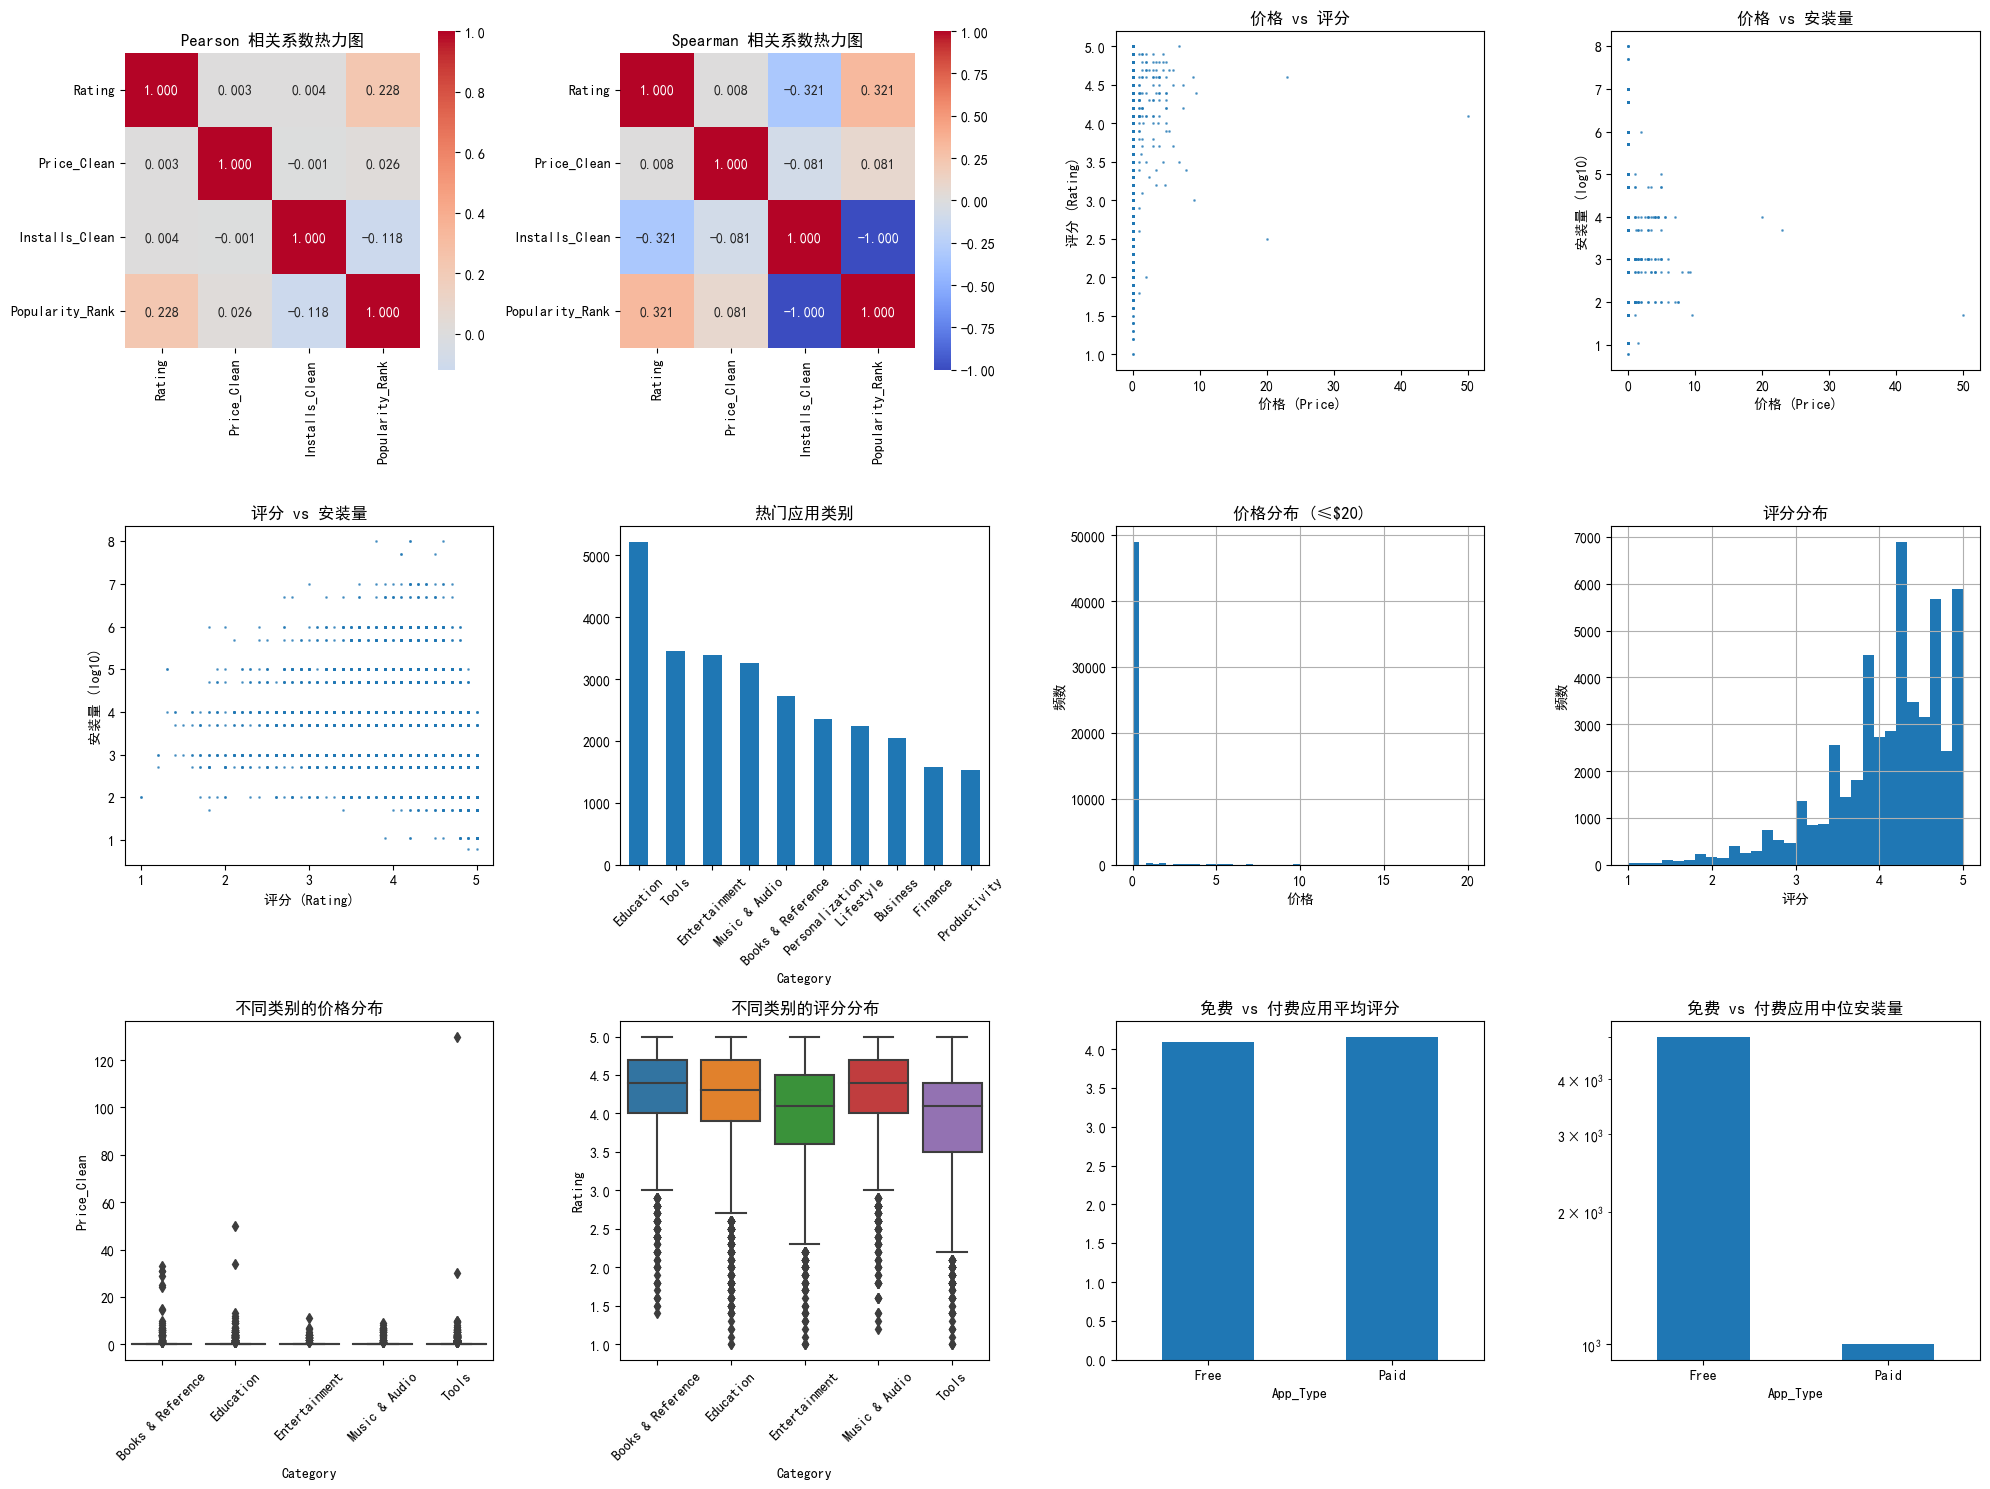

In [33]:
# ===============================
# 4. 数据可视化
# ===============================

plt.figure(figsize=(20, 15))

# 相关性热力图
plt.subplot(3, 4, 1)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Pearson 相关系数热力图')

plt.subplot(3, 4, 2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Spearman 相关系数热力图')

# 散点图分析（使用采样数据以提高性能）
plt.subplot(3, 4, 3)
sample_data = df_analysis.sample(min(5000, len(df_analysis)), random_state=42)
plt.scatter(sample_data['Price_Clean'], sample_data['Rating'], alpha=0.6, s=1)
plt.xlabel('价格 (Price)')
plt.ylabel('评分 (Rating)')
plt.title('价格 vs 评分')

plt.subplot(3, 4, 4)
plt.scatter(sample_data['Price_Clean'], np.log10(sample_data['Installs_Clean']+1), alpha=0.6, s=1)
plt.xlabel('价格 (Price)')
plt.ylabel('安装量 (log10)')
plt.title('价格 vs 安装量')

plt.subplot(3, 4, 5)
plt.scatter(sample_data['Rating'], np.log10(sample_data['Installs_Clean']+1), alpha=0.6, s=1)
plt.xlabel('评分 (Rating)')
plt.ylabel('安装量 (log10)')
plt.title('评分 vs 安装量')

# 不同类别的分布
plt.subplot(3, 4, 6)
top_categories = df_analysis['Category'].value_counts().head(10)
top_categories.plot(kind='bar')
plt.title('热门应用类别')
plt.xticks(rotation=45)

# 价格分布
plt.subplot(3, 4, 7)
df_analysis[df_analysis['Price_Clean'] <= 20]['Price_Clean'].hist(bins=50)
plt.xlabel('价格')
plt.ylabel('频数')
plt.title('价格分布 (≤$20)')

# 评分分布
plt.subplot(3, 4, 8)
df_analysis['Rating'].hist(bins=30)
plt.xlabel('评分')
plt.ylabel('频数')
plt.title('评分分布')

# 不同类别的价格箱线图
plt.subplot(3, 4, 9)
top_5_categories = df_analysis['Category'].value_counts().head(5).index
df_top_cat = df_analysis[df_analysis['Category'].isin(top_5_categories)]
sns.boxplot(data=df_top_cat, x='Category', y='Price_Clean')
plt.xticks(rotation=45)
plt.title('不同类别的价格分布')

# 不同类别的评分箱线图
plt.subplot(3, 4, 10)
sns.boxplot(data=df_top_cat, x='Category', y='Rating')
plt.xticks(rotation=45)
plt.title('不同类别的评分分布')

# 免费vs付费应用分析
plt.subplot(3, 4, 11)
df_analysis['App_Type'] = df_analysis['Price_Clean'].apply(lambda x: 'Free' if x == 0 else 'Paid')
app_type_stats = df_analysis.groupby('App_Type')['Rating'].mean()
app_type_stats.plot(kind='bar')
plt.title('免费 vs 付费应用平均评分')
plt.xticks(rotation=0)

plt.subplot(3, 4, 12)
app_install_stats = df_analysis.groupby('App_Type')['Installs_Clean'].median()
app_install_stats.plot(kind='bar')
plt.title('免费 vs 付费应用中位安装量')
plt.xticks(rotation=0)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [40]:
# ===============================
# 5.1 统计检验
# ===============================

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_statistical_testing(free_ratings, paid_ratings):
    """
    对两组数据进行全面的统计检验
    """
    print("=== 数据描述性统计 ===")
    print(f"免费应用: n={len(free_ratings)}, 均值={free_ratings.mean():.3f}, 标准差={free_ratings.std():.3f}")
    print(f"付费应用: n={len(paid_ratings)}, 均值={paid_ratings.mean():.3f}, 标准差={paid_ratings.std():.3f}")
    
    # 1. 正态性检验
    print("\n=== 正态性检验 ===")
    _, free_shapiro_p = stats.shapiro(free_ratings.sample(5000) if len(free_ratings) > 5000 else free_ratings)
    _, paid_shapiro_p = stats.shapiro(paid_ratings.sample(5000) if len(paid_ratings) > 5000 else paid_ratings)
    print(f"免费应用 Shapiro-Wilk检验 p值: {free_shapiro_p:.6f}")
    print(f"付费应用 Shapiro-Wilk检验 p值: {paid_shapiro_p:.6f}")
    
    # 2. 方差齐性检验
    print("\n=== 方差齐性检验 ===")
    _, levene_p = stats.levene(free_ratings, paid_ratings)
    print(f"Levene检验 p值: {levene_p:.6f}")
    
    # 3. 选择合适的检验方法
    print("\n=== 均值差异检验 ===")
    
    # 3.1 标准t检验（假设等方差）
    t_stat, t_p = stats.ttest_ind(free_ratings, paid_ratings, equal_var=True)
    print(f"标准t检验: t={t_stat:.4f}, p={t_p:.6f}")
    
    # 3.2 Welch t检验（不假设等方差）
    welch_t, welch_p = stats.ttest_ind(free_ratings, paid_ratings, equal_var=False)
    print(f"Welch t检验: t={welch_t:.4f}, p={welch_p:.6f}")
    
    # 3.3 Mann-Whitney U检验（非参数）
    u_stat, u_p = stats.mannwhitneyu(free_ratings, paid_ratings, alternative='two-sided')
    print(f"Mann-Whitney U检验: U={u_stat:.4f}, p={u_p:.6f}")
    
    # 3.4 Kolmogorov-Smirnov检验
    ks_stat, ks_p = stats.ks_2samp(free_ratings, paid_ratings)
    print(f"K-S检验: D={ks_stat:.4f}, p={ks_p:.6f}")
    
    # 4. 效应大小计算
    print("\n=== 效应大小 ===")
    # Cohen's d
    pooled_std = np.sqrt(((len(free_ratings)-1)*free_ratings.var() + 
                         (len(paid_ratings)-1)*paid_ratings.var()) / 
                        (len(free_ratings) + len(paid_ratings) - 2))
    cohens_d = (paid_ratings.mean() - free_ratings.mean()) / pooled_std
    print(f"Cohen's d: {cohens_d:.4f}")
    
    # 5. 推荐检验方法
    print("\n=== 检验方法推荐 ===")
    normal_free = free_shapiro_p > 0.05
    normal_paid = paid_shapiro_p > 0.05
    equal_var = levene_p > 0.05
    
    if normal_free and normal_paid:
        if equal_var:
            print("推荐: 标准t检验（数据正态分布且方差齐性）")
            recommended_p = t_p
        else:
            print("推荐: Welch t检验（数据正态分布但方差不齐）")
            recommended_p = welch_p
    else:
        print("推荐: Mann-Whitney U检验（数据非正态分布）")
        recommended_p = u_p
    
    print(f"推荐检验的p值: {recommended_p:.6f}")
    
    # 6. 结果解释
    print("\n=== 结果解释 ===")
    alpha = 0.05
    if recommended_p < alpha:
        print(f"结论: 在α={alpha}显著性水平下，拒绝原假设")
        print("付费应用与免费应用的评分存在显著差异")
    else:
        print(f"结论: 在α={alpha}显著性水平下，不能拒绝原假设")
        print("付费应用与免费应用的评分无显著差异")
    
    # 效应大小解释
    if abs(cohens_d) < 0.2:
        effect_size = "小"
    elif abs(cohens_d) < 0.5:
        effect_size = "中等"
    elif abs(cohens_d) < 0.8:
        effect_size = "大"
    else:
        effect_size = "非常大"
    
    print(f"效应大小: {effect_size} (Cohen's d = {cohens_d:.3f})")

def bootstrap_confidence_interval(data1, data2, n_bootstrap=10000, confidence=0.95):
    """
    使用Bootstrap方法计算均值差异的置信区间
    """
    bootstrap_diffs = []
    
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        bootstrap_diffs.append(np.mean(sample2) - np.mean(sample1))
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrap_diffs, 100 * alpha/2)
    upper = np.percentile(bootstrap_diffs, 100 * (1 - alpha/2))
    
    print(f"\n=== Bootstrap {confidence*100}%置信区间 ===")
    print(f"均值差异的{confidence*100}%置信区间: [{lower:.4f}, {upper:.4f}]")
    
    return lower, upper

# 使用示例：
comprehensive_statistical_testing(free_ratings, paid_ratings)
bootstrap_confidence_interval(free_ratings, paid_ratings)

=== 数据描述性统计 ===
免费应用: n=48908, 均值=4.097, 标准差=0.692
付费应用: n=1068, 均值=4.155, 标准差=0.594

=== 正态性检验 ===
免费应用 Shapiro-Wilk检验 p值: 0.000000
付费应用 Shapiro-Wilk检验 p值: 0.000000

=== 方差齐性检验 ===
Levene检验 p值: 0.000000

=== 均值差异检验 ===
标准t检验: t=-2.7121, p=0.006689
Welch t检验: t=-3.1398, p=0.001735
Mann-Whitney U检验: U=25340024.5000, p=0.095304
K-S检验: D=0.0554, p=0.003169

=== 效应大小 ===
Cohen's d: 0.0839

=== 检验方法推荐 ===
推荐: Mann-Whitney U检验（数据非正态分布）
推荐检验的p值: 0.095304

=== 结果解释 ===
结论: 在α=0.05显著性水平下，不能拒绝原假设
付费应用与免费应用的评分无显著差异
效应大小: 小 (Cohen's d = 0.084)

=== Bootstrap 95.0%置信区间 ===
均值差异的95.0%置信区间: [0.0221, 0.0941]


(0.02205157704184593, 0.09407277965753316)

In [34]:
# ===============================
# 5.2 统计检验
# ===============================

print("\n=== 统计显著性检验 ===")

# T检验：免费vs付费应用的评分差异
free_ratings = df_analysis[df_analysis['Price_Clean'] == 0]['Rating']
paid_ratings = df_analysis[df_analysis['Price_Clean'] > 0]['Rating']

t_stat, t_p_value = stats.ttest_ind(free_ratings, paid_ratings)
print(f"免费 vs 付费应用评分 t检验:")
print(f"t统计量: {t_stat:.4f}, p值: {t_p_value:.4f}")

# Mann-Whitney U检验（非参数检验）
u_stat, u_p_value = stats.mannwhitneyu(free_ratings, paid_ratings, alternative='two-sided')
print(f"Mann-Whitney U检验:")
print(f"U统计量: {u_stat:.4f}, p值: {u_p_value:.4f}")

# ===============================
# 6. NLP分析 - 应用名称特征提取
# ===============================

print("\n=== NLP特征提取 - 基于应用名称分析 ===")

# 下载NLTK数据（首次运行需要）
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# 文本预处理函数
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # 转小写
    text = text.lower()
    # 移除特殊字符和数字
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 分词
    tokens = word_tokenize(text)
    # 移除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# 预处理应用名称
df_analysis['App_Name_Clean'] = df_analysis['App Name'].apply(preprocess_text)

# 移除空应用名称
df_nlp = df_analysis[df_analysis['App_Name_Clean'].str.len() > 0].copy()

if len(df_nlp) > 0:
    # N-gram特征提取
    # Bi-gram分析
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=100, min_df=10)
    bigram_matrix = bigram_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    bigram_features = bigram_vectorizer.get_feature_names_out()
    
    # Tri-gram分析  
    trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=50, min_df=5)
    trigram_matrix = trigram_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    trigram_features = trigram_vectorizer.get_feature_names_out()
    
    print("最常见的Bi-grams (应用名称):")
    bigram_counts = np.sum(bigram_matrix.toarray(), axis=0)
    bigram_freq = list(zip(bigram_features, bigram_counts))
    bigram_freq.sort(key=lambda x: x[1], reverse=True)
    for feature, count in bigram_freq[:10]:
        print(f"'{feature}': {count}")
    
    print("\n最常见的Tri-grams (应用名称):")
    trigram_counts = np.sum(trigram_matrix.toarray(), axis=0)
    trigram_freq = list(zip(trigram_features, trigram_counts))
    trigram_freq.sort(key=lambda x: x[1], reverse=True)
    for feature, count in trigram_freq[:10]:
        print(f"'{feature}': {count}")
    
    # 聚类分析
    tfidf_vectorizer = TfidfVectorizer(max_features=200, min_df=10, max_df=0.8)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_nlp['App_Name_Clean'])
    
    # K-means聚类
    n_clusters = 8
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    df_nlp['Cluster'] = clusters
    
    print(f"\n应用聚类结果 (基于应用名称, K={n_clusters}):")
    for i in range(n_clusters):
        cluster_apps = df_nlp[df_nlp['Cluster'] == i]
        if len(cluster_apps) > 0:
            print(f"聚类 {i}: {len(cluster_apps)} 个应用")
            print(f"平均评分: {cluster_apps['Rating'].mean():.2f}")
            print(f"平均价格: ${cluster_apps['Price_Clean'].mean():.2f}")
            print(f"平均安装量: {cluster_apps['Installs_Clean'].mean():.0f}")
            # 显示聚类中最常见的词汇
            cluster_center = kmeans.cluster_centers_[i]
            top_features_idx = cluster_center.argsort()[-5:][::-1]
            feature_names = tfidf_vectorizer.get_feature_names_out()
            top_features = [feature_names[idx] for idx in top_features_idx]
            print(f"关键词: {', '.join(top_features)}")
            print()

    # 分析不同聚类的表现
    cluster_performance = df_nlp.groupby('Cluster').agg({
        'Rating': ['mean', 'std'],
        'Price_Clean': ['mean', 'median'],
        'Installs_Clean': ['mean', 'median'],
        'App Name': 'count'
    }).round(3)
    
    print("各聚类表现对比:")
    print(cluster_performance)



=== 统计显著性检验 ===
免费 vs 付费应用评分 t检验:
t统计量: -2.7121, p值: 0.0067
Mann-Whitney U检验:
U统计量: 25340024.5000, p值: 0.0953

=== NLP特征提取 - 基于应用名称分析 ===


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86173\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


最常见的Bi-grams (应用名称):
'live wallpaper': 382
'photo frame': 215
'photo editor': 203
'keyboard theme': 123
'escape game': 111
'puzzle game': 93
'video downloader': 89
'video call': 87
'launcher theme': 86
'icon pack': 82

最常见的Tri-grams (应用名称):
'tic tac toe': 29
'fake video call': 23
'free vpn proxy': 21
'mock test best': 21
'test best result': 21
'clock live wallpaper': 19
'best escape game': 18
'status saver whatsapp': 18
'sticker whatsapp wastickerapps': 16
'photo video maker': 14

应用聚类结果 (基于应用名称, K=8):
聚类 0: 40925 个应用
平均评分: 4.09
平均价格: $0.09
平均安装量: 276564
关键词: game, mobile, offline, video, theme

聚类 1: 731 个应用
平均评分: 3.94
平均价格: $0.01
平均安装量: 199035
关键词: photo, editor, frame, maker, video

聚类 2: 1102 个应用
平均评分: 4.04
平均价格: $0.02
平均安装量: 482407
关键词: free, game, vpn, ringtones, music

聚类 3: 422 个应用
平均评分: 4.04
平均价格: $2.07
平均安装量: 89729
关键词: pro, theme, sm, video, wallpaper

聚类 4: 774 个应用
平均评分: 4.37
平均价格: $0.01
平均安装量: 12745
关键词: radio, station, online, free, music

聚类 5: 342 个应用
平均评分: 4.18
平均价格: $

In [35]:
# ===============================
# 7. 分类别详细分析
# ===============================

print("\n=== 分类别详细分析 ===")

category_analysis = df_analysis.groupby('Category').agg({
    'Rating': ['mean', 'std', 'count'],
    'Price_Clean': ['mean', 'median'],
    'Installs_Clean': ['mean', 'median'],
    'App_Type': lambda x: (x == 'Free').mean()  # 免费应用比例
}).round(3)

category_analysis.columns = ['Rating_Mean', 'Rating_Std', 'App_Count', 
                           'Price_Mean', 'Price_Median', 
                           'Installs_Mean', 'Installs_Median', 'Free_Ratio']

# 只显示应用数量超过50的类别
popular_categories = category_analysis[category_analysis['App_Count'] >= 50].sort_values('Rating_Mean', ascending=False)
print("热门类别分析 (应用数量≥50):")
print(popular_categories)



=== 分类别详细分析 ===
热门类别分析 (应用数量≥50):
                         Rating_Mean  Rating_Std  App_Count  Price_Mean  \
Category                                                                  
Events                         4.327       0.660        152       0.000   
Books & Reference              4.291       0.572       2724       0.139   
Music & Audio                  4.289       0.573       3258       0.045   
Arcade                         4.271       0.607       1231       0.049   
Personalization                4.248       0.500       2349       0.105   
Puzzle                         4.216       0.565       1298       0.078   
Word                           4.195       0.576        238       0.103   
Education                      4.195       0.669       5212       0.083   
Shopping                       4.186       0.747       1333       0.010   
News & Magazines               4.170       0.691       1036       0.010   
Educational                    4.164       0.526        504      

In [36]:
# ===============================
# 8. 研究结论总结
# ===============================

print("\n=== 研究结论总结 ===")
print("1. 相关性分析结果:")
print(f"   - 价格与评分的Pearson相关系数: {pearson_corr.loc['Price_Clean', 'Rating']:.4f}")
print(f"   - 价格与安装量的Pearson相关系数: {pearson_corr.loc['Price_Clean', 'Installs_Clean']:.4f}")
print(f"   - 评分与安装量的Pearson相关系数: {pearson_corr.loc['Rating', 'Installs_Clean']:.4f}")

print(f"\n2. 显著性检验:")
print(f"   - 价格与评分显著性 (p值): {pearson_p_values.loc['Price_Clean', 'Rating']:.4f}")
print(f"   - 价格与安装量显著性 (p值): {pearson_p_values.loc['Price_Clean', 'Installs_Clean']:.4f}")
print(f"   - 评分与安装量显著性 (p值): {pearson_p_values.loc['Rating', 'Installs_Clean']:.4f}")

print(f"\n3. 免费vs付费应用:")
print(f"   - 免费应用平均评分: {free_ratings.mean():.2f}")
print(f"   - 付费应用平均评分: {paid_ratings.mean():.2f}")
print(f"   - 差异显著性 (p值): {t_p_value:.4f}")

print(f"\n4. 数据集概况:")
print(f"   - 原始数据集大小: {len(df)}")
print(f"   - 清洗后数据集大小: {len(df_clean)}")
print(f"   - 分析数据集大小: {len(df_analysis)}")
print(f"   - 免费应用比例: {(df_analysis['Price_Clean'] == 0).mean():.1%}")
print(f"   - 平均评分: {df_analysis['Rating'].mean():.2f}")
print(f"   - 平均价格: ${df_analysis['Price_Clean'].mean():.2f}")


=== 研究结论总结 ===
1. 相关性分析结果:
   - 价格与评分的Pearson相关系数: 0.0030
   - 价格与安装量的Pearson相关系数: -0.0014
   - 评分与安装量的Pearson相关系数: 0.0038

2. 显著性检验:
   - 价格与评分显著性 (p值): 0.5092
   - 价格与安装量显著性 (p值): 0.7528
   - 评分与安装量显著性 (p值): 0.3944

3. 免费vs付费应用:
   - 免费应用平均评分: 4.10
   - 付费应用平均评分: 4.15
   - 差异显著性 (p值): 0.0067

4. 数据集概况:
   - 原始数据集大小: 2312939
   - 清洗后数据集大小: 1230151
   - 分析数据集大小: 49976
   - 免费应用比例: 97.9%
   - 平均评分: 4.10
   - 平均价格: $0.10


In [37]:
# 保存结果
results_summary = {
    'pearson_correlation': pearson_corr,
    'spearman_correlation': spearman_corr,
    'pearson_p_values': pearson_p_values,
    'spearman_p_values': spearman_p_values,
    'category_analysis': popular_categories,
    'descriptive_stats': stats_summary
}

print("\n分析完成！结果已保存在 results_summary 字典中。")
print("建议在论文中重点讨论以下发现：")
print("1. 价格、评分、安装量之间的相关关系强度和方向")
print("2. 统计显著性检验结果及其意义") 
print("3. 不同应用类别之间的差异")
print("4. 免费与付费应用的特征对比")
print("5. NLP分析揭示的应用描述特征模式")


分析完成！结果已保存在 results_summary 字典中。
建议在论文中重点讨论以下发现：
1. 价格、评分、安装量之间的相关关系强度和方向
2. 统计显著性检验结果及其意义
3. 不同应用类别之间的差异
4. 免费与付费应用的特征对比
5. NLP分析揭示的应用描述特征模式
